# The L-Curve

Due both to the sparseness of the global observing network, and also to the efficiency of atmospheric mixing at erasing gradients arising fromsurface fluxes, the atmospheric inversion problem is frequently underdetermined.  In the face of such ill-posed inverse problems, flux dipoles and associated artifacts arise, and regularization techniques (such as Bayesian blending with priors) are applied.

Unregularized underconstrained problems are characterized by highly variable posterior fluxes, often with strong off-diagonal elements in the posterior covariance matrix. Regularizing the solution reduces the variance of the estimated fluxes.  This smoothing works by attenuating spurious fluxes arising from aggressive least squares fitting to observations.   Regularized results are smoother and more realistic, but they do not agree with observations as well.  The balance between realistic fluxes and small observational residuals is determined by the relative sizes of observation error $\mathbf{S_z}$ and prior flux error $\mathbf{S_x}$.  This Bayesian balance is expressed by the two terms of a typical cost function: 

$$J = (\mathbf{z} - \mathbf{H}\mathbf{x})^\text{T} \mathbf{S_z}^{-1} (\mathbf{z}-\mathbf{H}\mathbf{x}) + (\mathbf{x}-\mathbf{x_0})^\text{T} \mathbf{S_x}^{-1} (\mathbf{x}-\mathbf{x_0})$$

In many ill-posed problems, an optimal Bayesian balance can be found.  When the flux variance is plotted against the residuals variance as a function of the amount of regularization, a characteristic L-shaped curve often emerges.  The optimal solution is at the elbow of the L-curve, where most spurious fluxes have been attenuated without introducing significant residuals.

![Hansen L-curve image](hansen98a-fig4.1.png "Hansen 1998")

We vary the balance between the two parts of the cost function (matching measurements vs. matching priors) by scaling the prior covariance $\mathbf{S_x}$ by a factor we call "$\alpha$". In general, this balance is maintained by the magnitudes of $\mathbf{S_x}$ and $\mathbf{S_z}$. The L-curve diagnostic is useful in finding an optimal balance between these terms.

## References
P. C. Hansen. Rank-deficient and discrete ill-posed problems: numerical aspects of linear inversion. SIAM, 1998.


Loading Jacobians...24.7s
40 [...1...2....3....4...6....7....8....9...] 0.9s


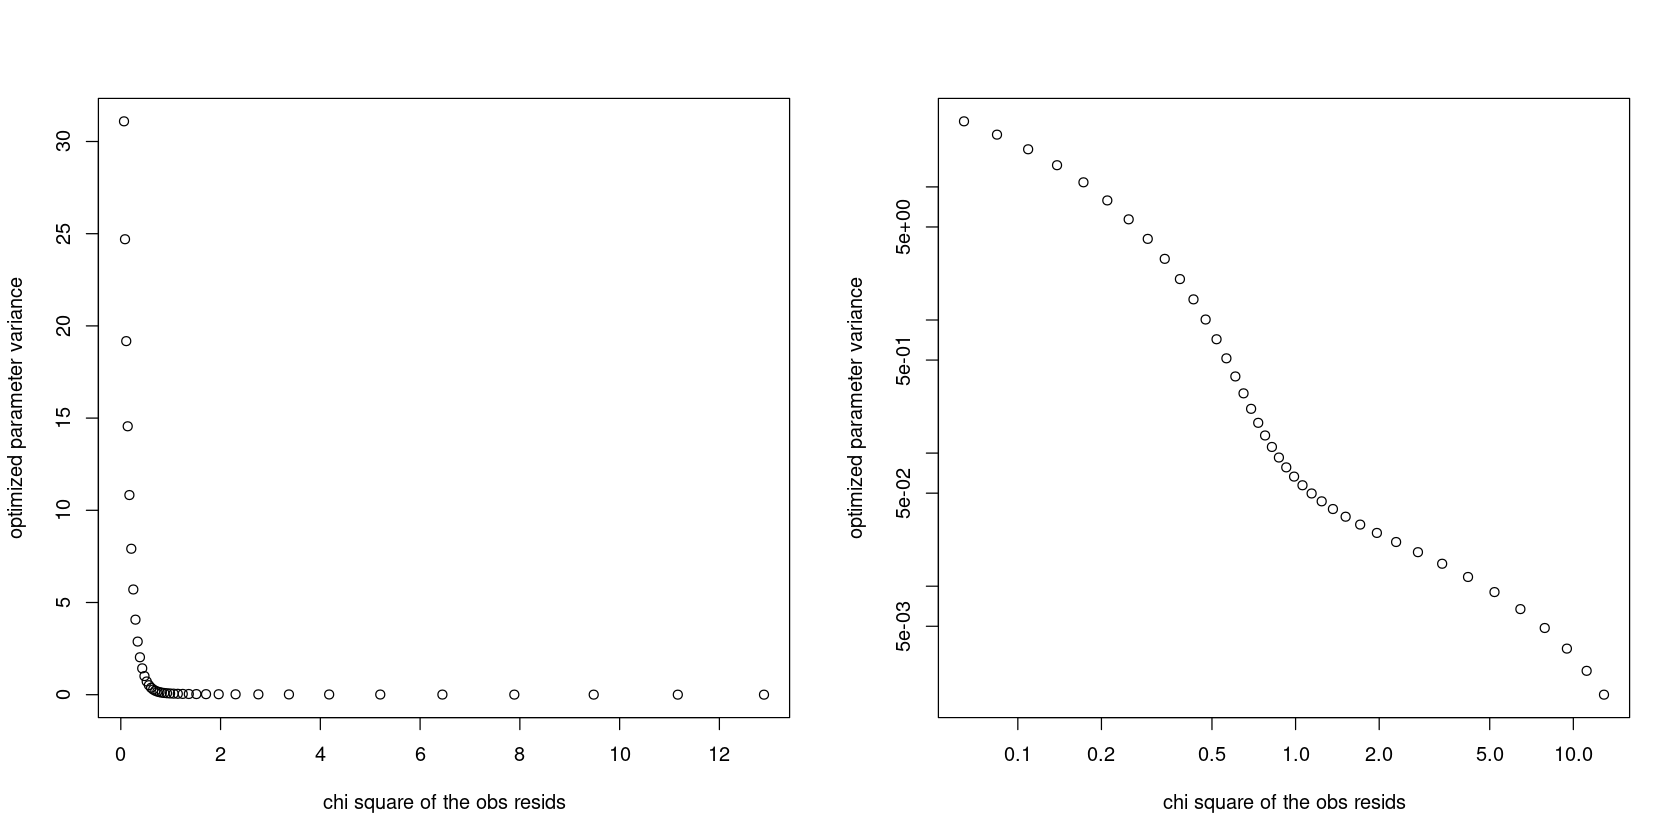

In [20]:
# Time-stamp: <hercules-login-1.hpc.msstate.edu:/work/noaa/co2/andy/Projects/enkf_summer_school/repo/ssim-ghg-2024/EnKF/L-curve/lc2.r: 26 May 2024 (Sun) 17:30:37 UTC>

source("../tools/enkf.r")
source("../tools/progress.bar.r")
source("../tools/find.indir.r")
indir <- find.indir()

alphas <-10^seq(-3,3,length.out=40)

nalphas <- length(alphas)
chi2.resids <- matrix(NA,nrow=1,ncol=nalphas)
chi2.flux <- matrix(NA,nrow=1,ncol=nalphas)
var.flux <- matrix(NA,nrow=1,ncol=nalphas)
                                      
# Load sensitivity matrices (Jacobians)
t0 <- proc.time()[3]
cat("Loading Jacobians...")
load(file.path(indir,"inversion_examples/jacobians/trunc_full_jacob_030624_with_dimnames_sib4_4x5_mask.rda"))
load(file.path(indir,"inversion_examples/jacobians/jacob_bgd_021624.rda"))
H <- jacob*(12/44) # Andrew reports units conversion needed
H_fixed <- jacob_bgd[,c(2,3)]
rm(jacob,jacob_bgd)
H.orig <- list()
H.orig$H <- H
H.orig$H_fixed <- H_fixed
cat(sprintf('%.1fs\n',proc.time()[3]-t0))

nobs <- dim(H)[1]

# One question often asked is what happens if we get the MDM
# wrong. You can check that below, by changing Szd.assumed to be
# different from Szd.actual.
Szd.actual <- rep(0.5,nobs) # variance in ppm^2
#Szd.assumed <- rep(0.1,nobs) # variance in ppm^2
Szd.assumed <- Szd.actual

nparms <- 22*24 # 22 regions, 24 months

Sx <- diag(rep(1,nparms))
truth_condition <- generate_ensemble(Sx=Sx,nmemb=1)
dim(truth_condition) <- c(nparms,1)

nobs <- dim(H)[1]
obs <- simulate_observed(H=H, x=truth_condition,H_fixed=H_fixed,Szd=Szd.actual)
dim(obs) <- c(nobs,1)

# Restrict to nobs randomly sampled subset of measurements. Could use
# obs_catalog or row.names of H to do more systematically-chosen
# subsets.
#
# The L-curve is typical of /under/-constrained problems, so we
# restrict to just a small number of observations.
nobs <- 200
lx <- sample(x=1:length(obs),size=nobs)
obs <- obs[lx,]
Szd.assumed <- Szd.assumed[lx]
Szd.actual <- Szd.actual[lx]
H <- H.orig$H[lx,]
H_fixed <- H.orig$H_fixed[lx,]

obs_fixed <- apply(H_fixed,c(1),sum)

pb <- progress.bar.start(nalphas)

ialpha <- 0
for (alpha in alphas) {
  ialpha <- ialpha + 1

  Sx.prior <- alpha*Sx 
  x.prior <- rep(0,nparms)
  
  
  # Kalman filter measurement update
  kf <- kf_meas_update(x=x.prior,Sx=Sx.prior,H=H,z=obs-obs_fixed,
                       Sz=diag(Szd.assumed))
  
  dobs <- matrix(simulate_observed(H=H, x=kf$x,H_fixed=H_fixed) - obs,nrow=nobs,ncol=1)
  dx <- matrix(kf$x - x.prior,nrow=nparms,ncol=1)
  
  chi2.resids[ialpha] <- (1/nobs) * t(dobs) %*% solve(diag(Szd.assumed)) %*% dobs
  chi2.flux[ialpha] <- (1/nparms) * t(dx) %*% solve(Sx.prior) %*% dx
  var.flux[ialpha] <- var(as.vector(kf$x))

  pb <- progress.bar.print(pb,ialpha)
} # alpha

progress.bar.end(pb)

# save(chi2.resids,chi2.flux,var.flux,alphas,file="lcurve.rda")

options(jupyter.plot_scale=1,repr.plot.height=7,repr.plot.width=14)
layout(matrix(1:2,nrow=1))
plot(chi2.resids, var.flux,xlab="chi square of the obs resids",ylab="optimized parameter variance")
plot(chi2.resids, var.flux,xlab="chi square of the obs resids",ylab="optimized parameter variance",log='xy')

